# Vector Autoregression
- Use VAR to make prediction, leveraging temperature information.
- Here the case is on zone 21. You may change to other zones by using data = df[df['zone_id]==id].

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests

df = pd.read_csv('aggr.csv')
total = df.groupby(['time','t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8',
       't9', 't10', 't11']).sum().reset_index() # zone 21
total['time'] = pd.to_datetime(total['time'])

### Preprocess
    Fill the empty slots with the value last year at the same time.

In [2]:
def preprocess():
    """
    Use the average temperature as the variable.
    Fill the missing value with the value in the same time of last year.
    """
    t_list = [f't{i}' for i in range(1,12)]
    df['t'] = df[t_list].mean(axis=1)
    total['t'] = total[t_list].mean(axis=1)
    nans = total[total['value'].isnull()]
    for (idx, row) in nans.iterrows():
        time = row['time']
        zid = row['zone_id']
        lastyear = time[:3]+str(int(time[3])-1)+time[4:]
        last = total[(total['time']==lastyear)&(total['zone_id']==zid)]
        total.set_value(idx,'value',last['value'])
        total.set_value(idx, 't', last['t'])
preprocess()

In [328]:
total[total['value'].isnull()]

Empty DataFrame
Columns: [time, zone_id, value, t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t11, t]
Index: []

### Grangers Test

As tested, the null hypothesis is rejected. Weather and energy loads are each other's Granger Cause.

In [62]:
maxlag=36
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df.fillna(0), variables =pd.Index(['t', 'value'])) 

E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueW

E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 33, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 34, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 35, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 36, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


t_x  value_x
t_y      1.0      0.0
value_y  0.0      1.0

In [5]:
grangers_causation_matrix(total, variables =pd.Index(['t', 'value'])) 

E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueW

E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 35, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
E:\Anaconda\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 36, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


t_x  value_x
t_y      1.0      0.0
value_y  0.0      1.0

### Cointegration Test
There exists significant statistical connections between energy loads and temperature.

In [6]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df[['value', 't']].fillna(0))
cointegration_test(total[['value', 't']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
value  ::  3625.88   > 12.3212   =>   True
t      ::  896.49    > 4.1296    =>   True
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
value  ::  340.16    > 12.3212   =>   True
t      ::  38.69     > 4.1296    =>   True


### Stationarity

As suggested by Adfuller Test, the time series is stationary already.

In [7]:
nobs = 7*24 + 18# int(df['t'].size * 0.01)
df = df.fillna(0)
data = total[0:-nobs]
df_train, df_test = data[['value', 't']][0:-nobs], data[['value', 't'
]][-nobs:]
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "value" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.5487
 No. Lags Chosen       = 51
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "t" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.451
 No. Lags Chosen       = 54
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [8]:
model = VAR(df_train)
model_fitted = model.fit(36)
# for i in [1,2,3,12,24,36,72]:
#     result = model.fit(i)
#     print('Lag Order =', i)
#     print('AIC : ', result.aic)
#     print('BIC : ', result.bic)
#     print('FPE : ', result.fpe)
#     print('HQIC: ', result.hqic, '\n')

### Have an overview of different lag selection

Choose lag = 36.

In [9]:
x = model.select_order(maxlags=36)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [10]:
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 17, Dec, 2019
Time:                     22:23:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    21.5257
Nobs:                     39006.0    HQIC:                   21.5038
Log likelihood:          -529739.    FPE:                2.16057e+09
AIC:                      21.4936    Det(Omega_mle):     2.15250e+09
--------------------------------------------------------------------
Results for equation value
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const         15197.389440      1655.345317            9.181           0.000
L1.value          1.283585         0.005087          252.314           0.000
L1.t          -5000.527684       294.945842          -16.954           0.000

### Residual Examination

Durbin Watson Statistic -> The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [12]:
# Check for Serial Correlation of Residuals (Errors) using 
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(df_train.columns, out):
    print(adjust(col), ':', round(val, 2))

value  : 2.0
t      : 2.0


In [25]:
total.reset_index()
lag_order = model_fitted.k_ar
print(lag_order)  #> 4
fc = model_fitted.forecast(y=df_test.values[-nobs:], steps=nobs)
df_forecast = pd.DataFrame(fc, index=total[['value', 't']].index[-nobs:], columns=total[['value', 't']].columns + '_pr')
ev = model_fitted.forecast(y=df_train.values[-1*nobs:], steps=nobs+1)
df_evaluate = pd.DataFrame(ev, index=total.index[-2*nobs: -nobs+1], columns=df_train.columns+'_ev')

36


In [26]:
df_evaluate

value_ev       t_ev
39042  2.221127e+06  79.970055
39043  2.150045e+06  76.036412
39044  2.078559e+06  71.614937
39045  1.999312e+06  68.498506
39046  1.858448e+06  66.372844
...             ...        ...
39224  1.583556e+06  64.789662
39225  1.690198e+06  67.007541
39226  1.787714e+06  69.106656
39227  1.866998e+06  70.979452
39228  1.921351e+06  72.517987

[187 rows x 2 columns]

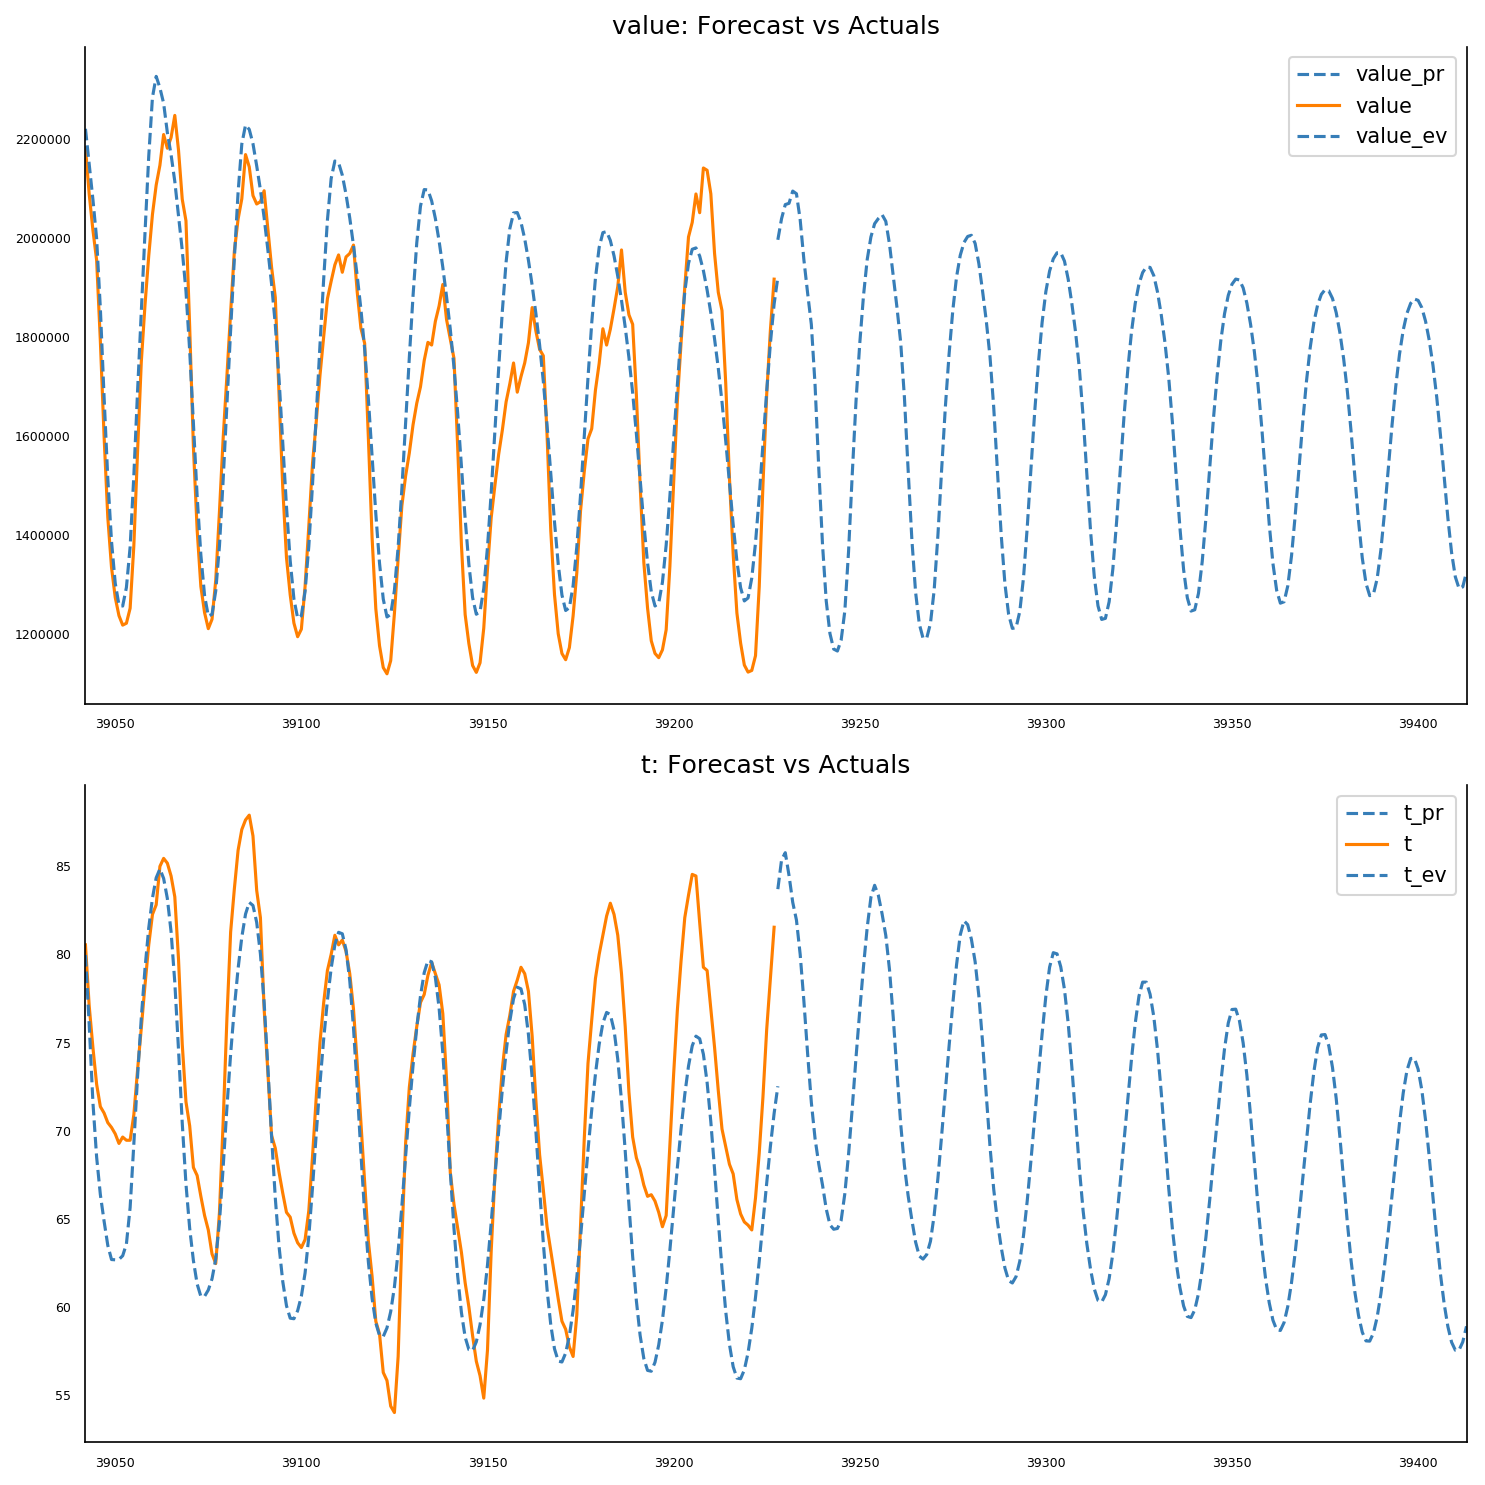

In [48]:
fig, axes = plt.subplots(nrows=int(len(df_train.columns)), ncols=1, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_train.columns, axes.flatten())):
    df_forecast[col+'_pr'].plot(linestyle='--',c='#377eb8',legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(c='#ff7f00', legend=True, ax=ax)
    df_evaluate[col+'_ev'].plot(linestyle='--',legend=True, ax=ax, c='#377eb8').autoscale(axis='x', tight=True)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Example to Work on a Particular Zone for Collaboration

In [57]:
def autocorr(x, lag):
    y = x - x.mean()
    result = np.correlate(y, y, mode='full')
    corr = result[result.size//2:][lag]
    var = np.var(y)
    return corr/var/len(x)
def evaMetrics(true, pred):
    delta = np.array([true[i+1]-true[i] for i in range(len(true)-1)]).sum() / len(true)
    err = true - pred
    se = err.sum() / 1000
    rmse = np.sqrt((err**2).mean())
    mae = abs(err).mean()
    mpe = (err/true).mean()*100
    mape = (abs(err)/true).mean()*100
    mase = err.mean() / delta / 1000
    acf = autocorr(err, 1)
    return [se, rmse, mae, mpe, mape, mase, acf]
def process(df, idx='Global', lag=36):
    df = df.fillna(0)
    data = df[0:-nobs]
    df_train, df_test = data[['value', 't']][0:-nobs], data[['value', 't'
    ]][-nobs:]
    model = VAR(df_train)
    model_fitted = model.fit(lag)
    out = durbin_watson(model_fitted.resid)
    for col, val in zip(df_train.columns, out):
        print(adjust(col), ':', round(val, 2))
    fc = model_fitted.forecast(y=df_test.values[-nobs:], steps=nobs)
    df_forecast = pd.DataFrame(fc, index=df[['value', 't']].index[-nobs:], columns=df[['value', 't']].columns + '_pr')
    ev = model_fitted.forecast(y=df_train.values, steps=nobs)
    df_evaluate = pd.DataFrame(ev[-24*7:], index=df.index[-nobs-24*7: -nobs], columns=df_train.columns+'_ev')
    fig, axes = plt.subplots(nrows=int(len(df_train.columns)), ncols=1, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(df_train.columns, axes.flatten())):
        df_forecast[col+'_pr'].plot(linestyle='--',c='#377eb8',legend=True, ax=ax).autoscale(axis='x',tight=True)
        df_test[col][-nobs:].plot(c='#ff7f00', legend=True, ax=ax)
        df_evaluate[col+'_ev'].plot(linestyle='--',legend=True, ax=ax, c='#377eb8').autoscale(axis='x', tight=True)
        ax.set_title(col + ": Forecast vs Actuals" + f' in Zone {idx} (lag = {lag})')
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
    # ax.tick_params(labelsize=6)
    plt.tight_layout();
    #plt.savefig(f'VAR/zone_{idx}_lag_{lag}.png')
    plt.show()
    res_pr = ev[-24*7:][:,1]
    ans = df[-nobs-24*7: -nobs]['t'].values
    return res_pr, ans

value  : 2.01
t      : 2.01


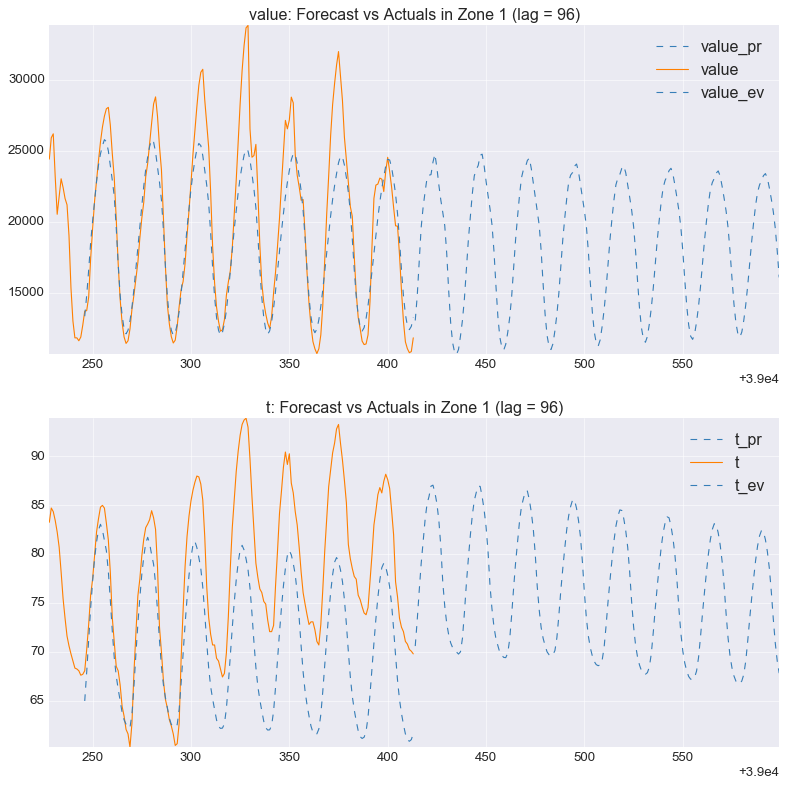

[-1.2332903810970017,
 8.6321086501207,
 7.468328644551514,
 -10.458039184920997,
 10.660713211444854,
 0.37100455986886677,
 0.975544830438459]

In [59]:
plt.style.use('seaborn-darkgrid')
a ,b = process(df[df['zone_id']==1], 1, 96)
evaMetrics(a,b)

### Collaboration

Generate .csv for comparison with other techniques.

In [153]:
total = pd.read_csv('aggr.csv')
total['t'] = total[t_list].mean(axis=1)
results = []
answers = []
lagList = [12, 24, 36, 48, 60, 72, 84, 96, 108]
for i in range(1, 21):
    result = []
    answer = []
    data = total[total['zone_id']==i]
    for lag in [12, 24, 36, 48, 60, 72, 84, 96, 108]:
        res, ans = process(data, i, lag)
        result.append(res)
        answer.append(ans)
    results.append(result)
    answers.append(answer)

In [215]:
metrics=[]
lagList = [12, 24, 36, 48, 60, 72, 84, 96, 108]
for zone in range(20):
    res =  []
    for lag in range(len(lagList)):
        pred = np.array([x[0] for x in results[zone][lag]])
        true = np.array([x[0] for x in answers[zone][lag]])
        print(pred, true, type(pred), type(true))
        e = evaMetrics(true, pred)
        res.append(e)
    metrics.append(res)
        

[15314.07861223 16071.80440649 17040.63052461 18119.10880467
 19203.36619543 20189.58199248 20986.58510157 21531.60928182
 21798.64963666 21791.79366611 21537.34166405 21075.73345808
 20456.62642766 19735.56917974 18966.35534368 18197.05690407
 17469.27683497 16818.98255955 16277.32717029 15870.59015921
 15619.7122957  15538.54859173 15631.69949449 15892.56221044
 16302.13104302 16829.6293502  17434.38583073 18068.80169494
 18682.393517   19226.56732168 19659.36880857 19949.29962459
 20077.82888233 20040.45599695 19846.3663706  19516.8293918
 19082.49331345 18580.04387256 18048.75614139 17527.33077352
 17051.21862438 16650.51633261 16348.47383132 16160.58230094
 16094.17533133 16148.46223633 16314.9271756  16578.07862682
 16916.54046421 17304.46517823 17713.23181767 18113.36372586
 18476.56215512 18777.70956093 18996.67599459 19119.76397362
 19140.6522076  19060.74373933 18888.88085985 18640.45675918
 18336.01907461 17999.50964388 17656.31142497 17331.27874331
 17046.91475146 16821.832

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

In [265]:
b

array([68.09090909, 70.27272727, 72.81818182, 75.81818182, 77.45454545,
       79.81818182, 82.27272727, 83.63636364, 84.81818182, 85.        ,
       84.72727273, 83.18181818, 81.45454545, 78.18181818, 73.54545455,
       71.09090909, 68.54545455, 68.09090909, 66.63636364, 64.45454545,
       63.45454545, 62.09090909, 61.63636364, 60.27272727, 62.72727273,
       67.81818182, 71.90909091, 75.72727273, 77.45454545, 79.81818182,
       81.54545455, 82.72727273, 83.09090909, 83.54545455, 84.45454545,
       83.72727273, 82.54545455, 78.63636364, 72.54545455, 70.        ,
       67.09090909, 65.18181818, 64.27272727, 63.09090909, 62.45454545,
       61.63636364, 60.45454545, 60.63636364, 62.72727273, 69.36363636,
       74.27272727, 78.72727273, 81.81818182, 83.90909091, 85.45454545,
       86.54545455, 87.36363636, 88.        , 87.90909091, 87.18181818,
       85.54545455, 81.81818182, 76.72727273, 73.54545455, 71.81818182,
       70.72727273, 70.72727273, 69.36363636, 69.09090909, 68.27